<a href="https://colab.research.google.com/github/peeush-agarwal/week-based-learning/blob/master/Projects/Devanagiri_Character_Recognizer/Devanagiri_Character_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
# Dataset: https://www.kaggle.com/rishianand/devanagari-character-set
# ! unzip '/content/drive/My Drive/Projects/Devanagiri Character Recognizer/Data/devanagari-character-set.zip'

Archive:  /content/drive/My Drive/Projects/Devanagiri Character Recognizer/Data/devanagari-character-set.zip
replace Images/Images/character_01_ka/10962.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
base_path = './Images/Images'

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

In [52]:
transformations = transforms.Compose([transforms.ToTensor()])
dataset = datasets.ImageFolder(base_path, transformations)
total_length = len(dataset)
validation_length = int(np.floor(0.3 * total_length))
print(total_length, validation_length)
trainset, validset = torch.utils.data.random_split(dataset, lengths=[total_length - validation_length, validation_length])
print(len(trainset))
print(len(validset))

92000 27600
64400
27600


In [0]:
batch_size = 8

In [0]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size, shuffle=False, num_workers=2)

In [55]:
print(dataset.classes)
print(len(dataset.classes))

['character_01_ka', 'character_02_kha', 'character_03_ga', 'character_04_gha', 'character_05_kna', 'character_06_cha', 'character_07_chha', 'character_08_ja', 'character_09_jha', 'character_10_yna', 'character_11_taamatar', 'character_12_thaa', 'character_13_daa', 'character_14_dhaa', 'character_15_adna', 'character_16_tabala', 'character_17_tha', 'character_18_da', 'character_19_dha', 'character_20_na', 'character_21_pa', 'character_22_pha', 'character_23_ba', 'character_24_bha', 'character_25_ma', 'character_26_yaw', 'character_27_ra', 'character_28_la', 'character_29_waw', 'character_30_motosaw', 'character_31_petchiryakha', 'character_32_patalosaw', 'character_33_ha', 'character_34_chhya', 'character_35_tra', 'character_36_gya', 'digit_0', 'digit_1', 'digit_2', 'digit_3', 'digit_4', 'digit_5', 'digit_6', 'digit_7', 'digit_8', 'digit_9']
46


In [0]:
def imshow(images, labels = None):
  images = torchvision.utils.make_grid(images)

  plt.figure(figsize=(4*images.size()[0], 4))
  plt.imshow(images.numpy().transpose((1, 2, 0)))
  plt.axis('off')
  if labels != None:
    plt.title([dataset.classes[label.item()] for label in labels])
  plt.show()

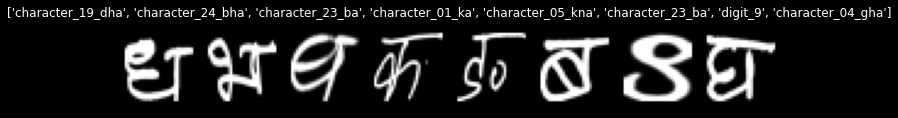

In [57]:
inputs, labels = next(iter(trainloader))
imshow(inputs, labels)

In [58]:
print(inputs[:1].shape)

torch.Size([1, 3, 32, 32])


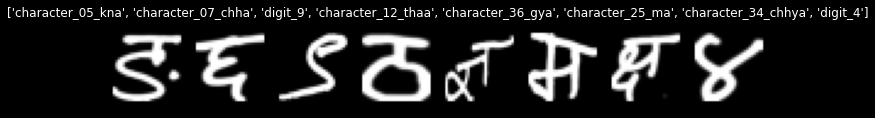

In [59]:
inputs, labels = next(iter(validloader))
imshow(inputs, labels)

In [60]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
batch_size = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validset, batch_size, shuffle=False, num_workers=2)

## Convolutional Neural Network

In [0]:
class Dev_CNN(nn.Module):
  def __init__(self):
    super(Dev_CNN, self).__init__()

    self.features = nn.Sequential(
        nn.Conv2d(3, 32, 5, 1, 1),      # (3, 32, 32) => (32, 30, 30)
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.Conv2d(32, 32, 5, 1, 1),     # (32, 30, 30) => (32, 28, 28)
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),      # (32, 28, 28) => (32, 14, 14)
        nn.Conv2d(32, 64, 5, 1, 1),     # (32, 14, 14) => (64, 12, 12)
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.Conv2d(64, 64, 5, 1, 1),     # (64, 12, 12) => (64, 10, 10)
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, stride=2),      # (64, 10, 10) => (64, 5, 5)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(64*5*5, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 46)
    )
  
  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size()[0], -1)
    out = self.classifier(out)
    return out

In [0]:
model = Dev_CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

In [64]:
%%time

model.train()

n_epochs = 20

epoch_losses = []
accuracies = []
for epoch in range(n_epochs):
  total = 0
  correct = 0
  running_loss = 0
  for batch_id, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total += len(labels)
    correct += (preds == labels).sum()

    running_loss += loss.item()

    if batch_id % (batch_size/4) == 0:
      print(f'Epoch:{epoch}, Batch:{batch_id}, Loss:{loss}, Acc:{100.0*correct/total}')
  
  epoch_loss = running_loss/len(trainloader)
  accuracy = 100.0 * correct /total
  print(f'Epoch:{epoch}, Loss:{epoch_loss}, Acc:{accuracy}')
  epoch_losses.append(epoch_loss)
  accuracies.append(accuracy)

Epoch:0, Batch:0, Loss:3.9502551555633545, Acc:1.953125
Epoch:0, Batch:64, Loss:2.0240590572357178, Acc:36.61057662963867
Epoch:0, Batch:128, Loss:0.8894221782684326, Acc:57.31589126586914
Epoch:0, Batch:192, Loss:0.5775050520896912, Acc:67.6833724975586
Epoch:0, Loss:1.3554315581208183, Acc:73.34317016601562
Epoch:1, Batch:0, Loss:0.39185887575149536, Acc:91.40625
Epoch:1, Batch:64, Loss:0.26157936453819275, Acc:94.03245544433594
Epoch:1, Batch:128, Loss:0.19057467579841614, Acc:94.86131286621094
Epoch:1, Batch:192, Loss:0.1683974415063858, Acc:95.23760986328125
Epoch:1, Loss:0.2366776079649017, Acc:95.46428680419922
Epoch:2, Batch:0, Loss:0.17670178413391113, Acc:96.09375
Epoch:2, Batch:64, Loss:0.18627309799194336, Acc:96.72476196289062
Epoch:2, Batch:128, Loss:0.14441293478012085, Acc:96.97492980957031
Epoch:2, Batch:192, Loss:0.09370699524879456, Acc:97.04703521728516
Epoch:2, Loss:0.13280529750599748, Acc:97.16149139404297
Epoch:3, Batch:0, Loss:0.11995387077331543, Acc:98.046875

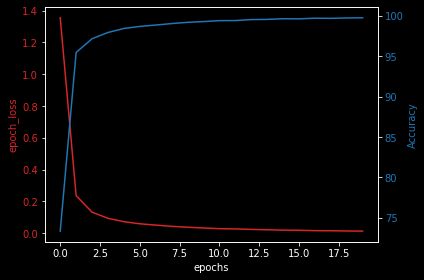

In [65]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('epoch_loss', color=color)
ax1.plot(range(n_epochs), epoch_losses, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(range(n_epochs), accuracies, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [66]:
classes_len = len(dataset.classes)

model.eval()

with torch.no_grad():
  running_loss = 0
  total = 0
  correct = 0
  conf_mat = np.zeros([classes_len, classes_len])
  for batch_id, data in enumerate(validloader, 0):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels)

    running_loss += loss.item()

    total += len(labels)
    correct += (preds == labels).sum()

    for x, y in zip(preds.cpu().numpy(), labels.cpu().numpy()):
      conf_mat[x][y] += 1

  print(f'Validation loss:{running_loss/len(validloader)}, Acc:{100.0*correct/total}')  

Validation loss:0.035298546207033925, Acc:98.98550415039062


In [0]:
best_model_path = '/content/drive/My Drive/Projects/Devanagiri Character Recognizer/models/best_model.pt'

In [0]:
def save_model(model):
  torch.save(model.state_dict(), best_model_path)

In [0]:
def load_model():
  model = Dev_CNN()
  model.load_state_dict(torch.load(best_model_path))
  model.eval()
  return model

In [0]:
save_model(model)

In [0]:
model = load_model()

In [0]:
def make_predictions(dataloader, number):
  images, labels = next(iter(dataloader))
  img = images[number].view(1, 3, 32, 32)
  with torch.no_grad():
    output = model(img)

  _, pred_idx = torch.max(output.data, 1)
  
  softmax_layer = nn.Softmax(dim=1)
  pred = softmax_layer(output)
  pred = pred.data.numpy().squeeze()
  accuracy = pred[pred_idx]

  fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), ncols=2)
  ax1.imshow(img[0].numpy().transpose((1, 2, 0)))
  ax1.axis("off")
  ax2.barh(np.arange(46), pred)
  ax2.set_aspect(0.1)
  ax2.set_yticks(np.arange(46))
  ax2.set_yticklabels(list(dataset.classes))
  ax2.set_title(f'Highest Probability Of a class, acc:{100.0*accuracy:.2f}%')
  ax2.set_xlim(0, 1.1)

  plt.tight_layout()

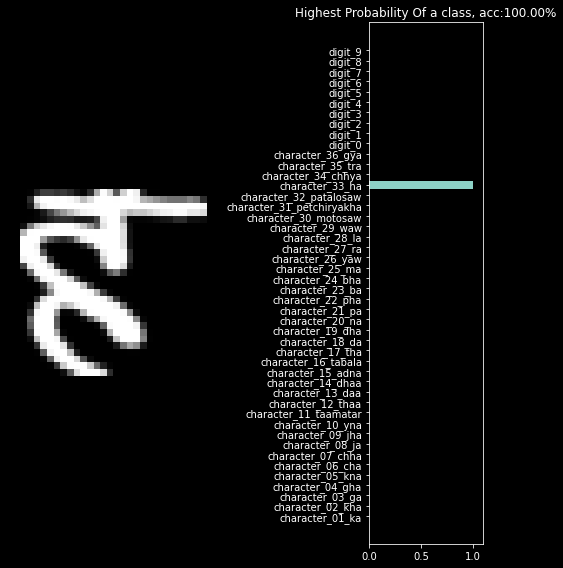

In [135]:
rand_idx = np.random.randint(0, batch_size-1)
make_predictions(validloader, rand_idx)

In [0]:
def plot_conf_matrix(confusion_matrix, classes_len):
  classes = np.arange(classes_len)
  fig, ax = plt.subplots(figsize=(20, 20))
  im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(confusion_matrix.shape[1]),
          yticks=np.arange(confusion_matrix.shape[0]),
          xticklabels=classes, yticklabels=classes,
          ylabel='True label',
          xlabel='Predicted label',
          title='Epoch %d' % epoch)
  thresh = confusion_matrix.max() / 2.
  for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          ax.text(j, i, int(confusion_matrix[i, j]),
                  ha="center", va="center",
                  color="white" if confusion_matrix[i, j] > thresh else "black")
  fig.tight_layout()

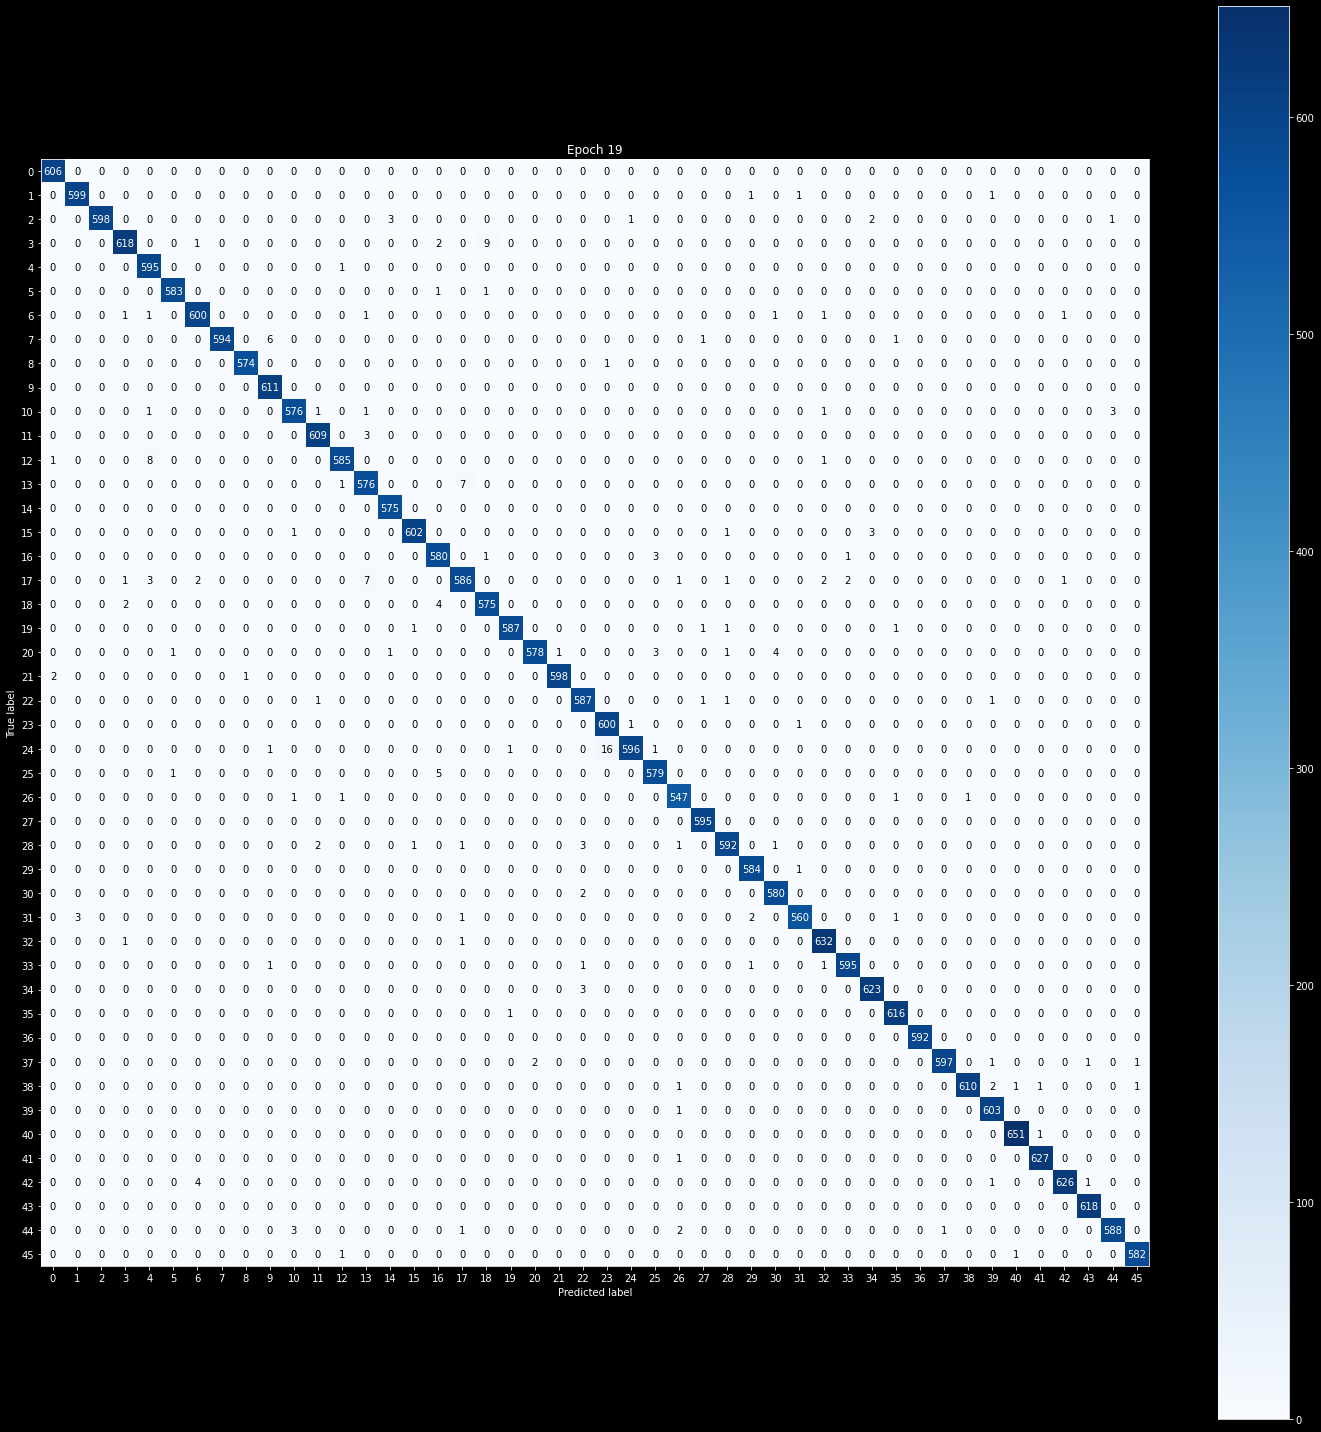

In [0]:
plot_conf_matrix(conf_mat, classes_len)